# Logistic Regression with Deep neural network 

This project will be step-by-step building the neural network from scratch, including running forward and backward propagation and model optimization. 

# Importing libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import pickle
from genderdf import *

# Define activation function
In this project, we are going to use sigmoid and RELU (Rectified Linear Unit) activation functions.

In [7]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache=Z
    return A,cache

def relu(Z):
    A=np.maximum(0,Z)
    cache = Z
    return A,cache

def sigmoid_backward(dA,cache):
    Z=cache
    s=1/(1+np.exp(-Z))
    dZ=dA*s*(1-s) #s*(1-s) is the derivative of the function
    return dZ

def relu_backward(dA,cache):
    Z=cache
    dZ=np.array(dA,copy=True)
    dZ[Z<=0]=0
    return dZ

# Create parameters (weights and bias)

The two main parameters for neural network is the weights (w) and bias (b)

In [8]:
def initialize_parameters_deep(layers_dims):
    np.random.seed(1)
    L=len(layers_dims)
    parameters = {}
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1])/np.sqrt(layers_dims[l-1])
        parameters[f'b{l}']=np.zeros((layers_dims[l],1))

    return parameters

# Forward Propagation
## Linear function

This linear function will compute the linear equation (weight*input+bias) which is a simple linear regression equation

In [9]:
def linear_forward(A,W,b):
    Z=np.dot(W,A)+b
    cache=(A,W,b)
    return Z,cache

## Activate the linear function using activation functions (sigmoid and RELU)

for layer 0 to n-1 where n=output layer, we use RELU function which is the maximum (0,Z) where Z=linear equation.    

for the output layer, we use sigmoid function which is a commom activation function for logistic regression to activate the linear equation

In [10]:
def linear_activation_forward(A_prev,W,b,activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation=='sigmoid':
        A,activation_cache=sigmoid(Z)
    elif activation=='relu':
        A,activation_cache=relu(Z)
    cache=(linear_cache,activation_cache)
    return A,cache


## Compute the final output

Now we put all functions together to finish our forward propagation and produce the output y-hat

In [11]:
def L_model_forward(X,parameters):
    caches=[]
    A=X
    L=len(parameters)//2
    for l in range(1,L):
        A_prev=A
        A,cache=linear_activation_forward(A_prev,parameters[f'W{l}'],parameters[f'b{l}'],activation='relu')
        caches.append(cache)
    AL,cache=linear_activation_forward(A,parameters[f'W{L}'],parameters[f'b{L}'],activation='sigmoid')
    caches.append(cache)
    return AL,caches

# Cost Function

The cost is the average of the loss function which is  -(1 / m) * (np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T))

One of the goals for this project is to minimize the cost function so that the model is optimized

In [12]:
def compute_cost(AL,Y):
    m=Y.shape[1]
    cost = (1. / m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T))
    cost=np.squeeze(cost)
    return cost

# Backward propagation

## Derivative of the sigmoid and RELU functions

We reached to the output layer to compute the final output y-hat.

Now, we will be computing the gradient descent to find the optimal weight and bias so that the cost function is minimized.

In [13]:
def linear_backward(dZ,cache):
    A_prev,W,b=cache
    m=A_prev.shape[1]
    dW=np.dot(dZ,A_prev.T)/m
    db=np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.dot(W.T,dZ)
    return dA_prev,dW,db

## Backward linear activation

This time we start from the output layer which was activated by a sigmoid function. 

Then we repeatedly compute the derivative of the RELU function form layer n-1 to the input layer where n=output layer.

In [14]:
def linear_activation_backward(dA,cache,activation):
    linear_cache, activation_cache = cache  #linear_cache contain a,w,b #activation_cache contain Z
    if activation=='sigmoid':
        dZ=sigmoid_backward(dA,activation_cache)
    elif activation=='relu':
        dZ = relu_backward(dA, activation_cache)
    dA_prev,dW,db=linear_backward(dZ,linear_cache)
    return dA_prev,dW,db

In [15]:
def L_model_backward(AL,Y,caches):
    L=len(caches)
    grads={}
    m=AL.shape[1]
    Y=Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache=caches[-1]
    dA_prev,dW,db=linear_activation_backward(dAL,current_cache,activation='sigmoid')
    grads[f'dA{L-1}']=dA_prev
    grads[f'dW{L}']=dW
    grads[f'db{L}'] = db
    for l in reversed(range(L-1)):
        current_cache=caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,
                                                                    activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

# Finding the optimal weights and bias 

The following function will continuously update the parameters to find the global minimum for the cost function

In [16]:
def update_parameters(params,grads,learning_rate):
    parameters=params.copy()
    L=len(parameters)//2
    for l in range(L):
        parameters[f'W{l+1}']-=learning_rate*grads['dW'+ str(l+1)]
        parameters[f'b{l + 1}']-= learning_rate * grads['db' + str(l + 1)]
    return parameters


# Putting all together

Now we have a model that iterates over 2500 times to gradually reduce the costs.

The process for the "for" loop is the following:

- Compute the final output using the parameters (w,b)
- Compute the cost
- Compute the gradients
- updating the parameters (w,b) by subtracting the gradient*learning rate
- repeat from step 1 with the new parameters (w,b)


In [17]:
def L_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations=2500,print_cost=False):
    costs=[]
    parameters=initialize_parameters_deep(layers_dims)
    for i in range(num_iterations):
        AL,caches=L_model_forward(X,parameters)
        cost=compute_cost(AL,Y)
        grads=L_model_backward(AL,Y,caches)
        parameters=update_parameters(parameters,grads,learning_rate)
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

In [18]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network
    p = np.zeros((1, m))

    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    print("Accuracy: " + str(np.sum((p == y) / m)))

    return p

# Input file

The dataset we're going to use is 'gender_df' which has every column=a (64,64,3) picture represented by an array with shape (12288,1) and every row=number of examples in the dataset

This will take 5 minutes to run

In [2]:
gender_df=create_df()

progress: 0.02%
progress: 0.05%
progress: 0.07%
progress: 0.10%
progress: 0.12%
progress: 0.14%
progress: 0.17%
progress: 0.19%
progress: 0.21%
progress: 0.24%
progress: 0.26%
progress: 0.29%
progress: 0.31%
progress: 0.33%
progress: 0.36%
progress: 0.38%
progress: 0.41%
progress: 0.43%
progress: 0.45%
progress: 0.48%
progress: 0.50%
progress: 0.52%
progress: 0.55%
progress: 0.57%
progress: 0.60%
progress: 0.62%
progress: 0.64%
progress: 0.67%
progress: 0.69%
progress: 0.72%
progress: 0.74%
progress: 0.76%
progress: 0.79%
progress: 0.81%
progress: 0.83%
progress: 0.86%
progress: 0.88%
progress: 0.91%
progress: 0.93%
progress: 0.95%
progress: 0.98%
progress: 1.00%
progress: 1.03%
progress: 1.05%
progress: 1.07%
progress: 1.10%
progress: 1.12%
progress: 1.14%
progress: 1.17%
progress: 1.19%
progress: 1.22%
progress: 1.24%
progress: 1.26%
progress: 1.29%
progress: 1.31%
progress: 1.34%
progress: 1.36%
progress: 1.38%
progress: 1.41%
progress: 1.43%
progress: 1.45%
progress: 1.48%
progress

progress: 12.21%
progress: 12.23%
progress: 12.26%
progress: 12.28%
progress: 12.30%
progress: 12.33%
progress: 12.35%
progress: 12.37%
progress: 12.40%
progress: 12.42%
progress: 12.45%
progress: 12.47%
progress: 12.49%
progress: 12.52%
progress: 12.54%
progress: 12.57%
progress: 12.59%
progress: 12.61%
progress: 12.64%
progress: 12.66%
progress: 12.68%
progress: 12.71%
progress: 12.73%
progress: 12.76%
progress: 12.78%
progress: 12.80%
progress: 12.83%
progress: 12.85%
progress: 12.88%
progress: 12.90%
progress: 12.92%
progress: 12.95%
progress: 12.97%
progress: 13.02%
progress: 13.04%
progress: 13.07%
progress: 13.09%
progress: 13.11%
progress: 13.14%
progress: 13.16%
progress: 13.19%
progress: 13.21%
progress: 13.23%
progress: 13.26%
progress: 13.28%
progress: 13.30%
progress: 13.33%
progress: 13.35%
progress: 13.38%
progress: 13.40%
progress: 13.42%
progress: 13.45%
progress: 13.47%
progress: 13.50%
progress: 13.52%
progress: 13.54%
progress: 13.57%
progress: 13.59%
progress: 13.6

progress: 23.75%
progress: 23.77%
progress: 23.80%
progress: 23.82%
progress: 23.84%
progress: 23.87%
progress: 23.89%
progress: 23.92%
progress: 23.94%
progress: 23.96%
progress: 23.99%
progress: 24.01%
progress: 24.03%
progress: 24.06%
progress: 24.08%
progress: 24.11%
progress: 24.13%
progress: 24.15%
progress: 24.18%
progress: 24.20%
progress: 24.23%
progress: 24.25%
progress: 24.27%
progress: 24.30%
progress: 24.32%
progress: 24.34%
progress: 24.37%
progress: 24.39%
progress: 24.42%
progress: 24.44%
progress: 24.46%
progress: 24.49%
progress: 24.51%
progress: 24.54%
progress: 24.56%
progress: 24.58%
progress: 24.61%
progress: 24.63%
progress: 24.65%
progress: 24.68%
progress: 24.70%
progress: 24.73%
progress: 24.75%
progress: 24.77%
progress: 24.80%
progress: 24.82%
progress: 24.85%
progress: 24.87%
progress: 24.89%
progress: 24.92%
progress: 24.94%
progress: 24.96%
progress: 24.99%
progress: 25.01%
progress: 25.04%
progress: 25.06%
progress: 25.08%
progress: 25.11%
progress: 25.1

progress: 35.31%
progress: 35.34%
progress: 35.36%
progress: 35.38%
progress: 35.41%
progress: 35.43%
progress: 35.46%
progress: 35.48%
progress: 35.50%
progress: 35.53%
progress: 35.55%
progress: 35.57%
progress: 35.60%
progress: 35.65%
progress: 35.67%
progress: 35.69%
progress: 35.72%
progress: 35.74%
progress: 35.77%
progress: 35.79%
progress: 35.81%
progress: 35.84%
progress: 35.86%
progress: 35.88%
progress: 35.91%
progress: 35.93%
progress: 35.96%
progress: 35.98%
progress: 36.00%
progress: 36.03%
progress: 36.05%
progress: 36.08%
progress: 36.10%
progress: 36.12%
progress: 36.15%
progress: 36.17%
progress: 36.19%
progress: 36.22%
progress: 36.24%
progress: 36.27%
progress: 36.29%
progress: 36.31%
progress: 36.34%
progress: 36.36%
progress: 36.39%
progress: 36.41%
progress: 36.43%
progress: 36.46%
progress: 36.48%
progress: 36.50%
progress: 36.53%
progress: 36.55%
progress: 36.58%
progress: 36.60%
progress: 36.62%
progress: 36.65%
progress: 36.67%
progress: 36.70%
progress: 36.7

progress: 47.00%
progress: 47.02%
progress: 47.04%
progress: 47.07%
progress: 47.09%
progress: 47.11%
progress: 47.14%
progress: 47.16%
progress: 47.19%
progress: 47.21%
progress: 47.23%
progress: 47.26%
progress: 47.28%
progress: 47.31%
progress: 47.33%
progress: 47.35%
progress: 47.38%
progress: 47.40%
progress: 47.42%
progress: 47.45%
progress: 47.47%
progress: 47.50%
progress: 47.52%
progress: 47.54%
progress: 47.57%
progress: 47.59%
progress: 47.62%
progress: 47.64%
progress: 47.66%
progress: 47.69%
progress: 47.71%
progress: 47.73%
progress: 47.76%
progress: 47.78%
progress: 47.81%
progress: 47.83%
progress: 47.85%
progress: 47.88%
progress: 47.90%
progress: 47.93%
progress: 47.95%
progress: 47.97%
progress: 48.00%
progress: 48.02%
progress: 48.04%
progress: 48.07%
progress: 48.09%
progress: 48.12%
progress: 48.14%
progress: 48.16%
progress: 48.19%
progress: 48.21%
progress: 48.24%
progress: 48.26%
progress: 48.28%
progress: 48.31%
progress: 48.33%
progress: 48.35%
progress: 48.3

progress: 61.08%
progress: 61.11%
progress: 61.15%
progress: 61.18%
progress: 61.21%
progress: 61.24%
progress: 61.27%
progress: 61.33%
progress: 61.36%
progress: 61.39%
progress: 61.42%
progress: 61.46%
progress: 61.49%
progress: 61.52%
progress: 61.55%
progress: 61.58%
progress: 61.61%
progress: 61.64%
progress: 61.67%
progress: 61.70%
progress: 61.73%
progress: 61.76%
progress: 61.80%
progress: 61.83%
progress: 61.86%
progress: 61.89%
progress: 61.92%
progress: 61.95%
progress: 61.98%
progress: 62.01%
progress: 62.04%
progress: 62.07%
progress: 62.11%
progress: 62.14%
progress: 62.17%
progress: 62.20%
progress: 62.23%
progress: 62.26%
progress: 62.29%
progress: 62.32%
progress: 62.35%
progress: 62.38%
progress: 62.41%
progress: 62.45%
progress: 62.48%
progress: 62.51%
progress: 62.54%
progress: 62.57%
progress: 62.60%
progress: 62.63%
progress: 62.66%
progress: 62.69%
progress: 62.72%
progress: 62.76%
progress: 62.79%
progress: 62.82%
progress: 62.85%
progress: 62.88%
progress: 62.9

progress: 76.13%
progress: 76.16%
progress: 76.19%
progress: 76.22%
progress: 76.25%
progress: 76.28%
progress: 76.32%
progress: 76.35%
progress: 76.38%
progress: 76.41%
progress: 76.44%
progress: 76.47%
progress: 76.50%
progress: 76.53%
progress: 76.56%
progress: 76.59%
progress: 76.63%
progress: 76.66%
progress: 76.69%
progress: 76.72%
progress: 76.75%
progress: 76.78%
progress: 76.81%
progress: 76.84%
progress: 76.87%
progress: 76.90%
progress: 76.93%
progress: 76.97%
progress: 77.00%
progress: 77.03%
progress: 77.06%
progress: 77.09%
progress: 77.12%
progress: 77.15%
progress: 77.18%
progress: 77.21%
progress: 77.24%
progress: 77.28%
progress: 77.31%
progress: 77.34%
progress: 77.37%
progress: 77.40%
progress: 77.43%
progress: 77.46%
progress: 77.49%
progress: 77.52%
progress: 77.55%
progress: 77.59%
progress: 77.62%
progress: 77.65%
progress: 77.68%
progress: 77.71%
progress: 77.74%
progress: 77.77%
progress: 77.80%
progress: 77.83%
progress: 77.86%
progress: 77.89%
progress: 77.9

progress: 91.15%
progress: 91.18%
progress: 91.21%
progress: 91.24%
progress: 91.27%
progress: 91.30%
progress: 91.33%
progress: 91.36%
progress: 91.39%
progress: 91.42%
progress: 91.46%
progress: 91.49%
progress: 91.52%
progress: 91.55%
progress: 91.58%
progress: 91.61%
progress: 91.64%
progress: 91.67%
progress: 91.70%
progress: 91.73%
progress: 91.76%
progress: 91.80%
progress: 91.83%
progress: 91.86%
progress: 91.89%
progress: 91.92%
progress: 91.95%
progress: 91.98%
progress: 92.01%
progress: 92.04%
progress: 92.07%
progress: 92.11%
progress: 92.14%
progress: 92.17%
progress: 92.20%
progress: 92.23%
progress: 92.26%
progress: 92.29%
progress: 92.32%
progress: 92.35%
progress: 92.38%
progress: 92.41%
progress: 92.45%
progress: 92.48%
progress: 92.51%
progress: 92.54%
progress: 92.57%
progress: 92.60%
progress: 92.63%
progress: 92.66%
progress: 92.69%
progress: 92.72%
progress: 92.76%
progress: 92.79%
progress: 92.82%
progress: 92.85%
progress: 92.88%
progress: 92.91%
progress: 92.9

# Isolate the y-variable

Note that the last row of "gender_df" contains a list of 1's(Male) and 0's (Female). 

In [3]:
y_orig=gender_df.iloc[12288].values
gender_df.drop(12288,inplace=True)
y=y_orig.reshape(1,y_orig.shape[0])

# Spliting the dataset

In order to use the train_test_split function, we need to make sure the x.shape[0]== y.shape[0].

After running the function, we can use the transpose function to make x and y variables the correct shape

test_x.shape= (12288,2949) # 12288 is the input array for the picture, 3011 is the numbers of example.

test_y.shape= (1,2949) 

In [19]:
train_x_orig, test_x_orig, train_y, test_y = train_test_split(gender_df.values.T, y.T, test_size=0.20, random_state=42)
train_x=train_x_orig.T/255
test_x=test_x_orig.T/255
train_y=train_y.T
test_y=test_y.T

In [20]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(12288, 2949)
(12288, 738)
(1, 2949)
(1, 738)


# Train the model 
This will take 5 minutes to run.

In [28]:
layers_dims=[train_x.shape[0],20,7,1]
parameters, costs=L_layer_model(train_x,train_y,layers_dims,print_cost=True)

Cost after iteration 0: 0.6920989407037795
Cost after iteration 100: 0.6545093934119316
Cost after iteration 200: 0.6493153958690927
Cost after iteration 300: 0.6448309346954649
Cost after iteration 400: 0.6293896696268212
Cost after iteration 500: 0.6307378588764398
Cost after iteration 600: 0.6300577551850068
Cost after iteration 700: 0.6103767238184639
Cost after iteration 800: 0.6640409684520456
Cost after iteration 900: 0.574707601765503
Cost after iteration 1000: 0.619224200228512
Cost after iteration 1100: 0.6660438392584003
Cost after iteration 1200: 0.5474641332082268
Cost after iteration 1300: 0.5788092267834383
Cost after iteration 1400: 0.530552491507071
Cost after iteration 1500: 0.5207563312639163
Cost after iteration 1600: 0.5678626495774393
Cost after iteration 1700: 0.5605867823830366
Cost after iteration 1800: 0.49888305680757444
Cost after iteration 1900: 0.49581625152682557
Cost after iteration 2000: 0.5943843406039332
Cost after iteration 2100: 0.47549740806133556


In [29]:
pred_train = predict(train_x,train_y,parameters)
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8033231603933539
Accuracy: 0.6355013550135502


# Make a prediction with an image

In [23]:
def single_predictiion(X, parameters):
    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network

    probas, caches = L_model_forward(X, parameters)
    if probas > 0.5:
        p='Male'
    elif probas <=0.5:
        p='Female'
    return p

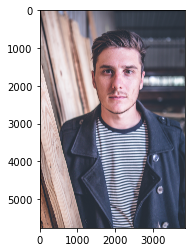

In [24]:
fname='timothy-barlin-FGaknWvNbBk-unsplash.jpg' 
image=np.array(Image.open(fname))
plt.imshow(image)

In [25]:
image=np.array(Image.open(fname).resize((64, 64))) # conver the pixel into (64,64,3) format
image=image/255 
image1=image.reshape(image.shape[0]*image.shape[1]*image.shape[2],1)
print(f'The model predicts it is a {single_predictiion(image1,parameters)} picture!')

The model predicts it is a Male picture!
